In [27]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
train_csv = pd.read_csv('Handwriting_Recognition/written_name_train_v2.csv')
val_csv = pd.read_csv('Handwriting_Recognition/written_name_validation_v2.csv')
train_img_dir = 'Handwriting_Recognition/train_v2/train'
val_img_dir = 'Handwriting_Recognition/validation_v2/validation'
print(train_csv.shape[0], val_csv.shape[0])
train_csv.head(5)

330961 41370


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


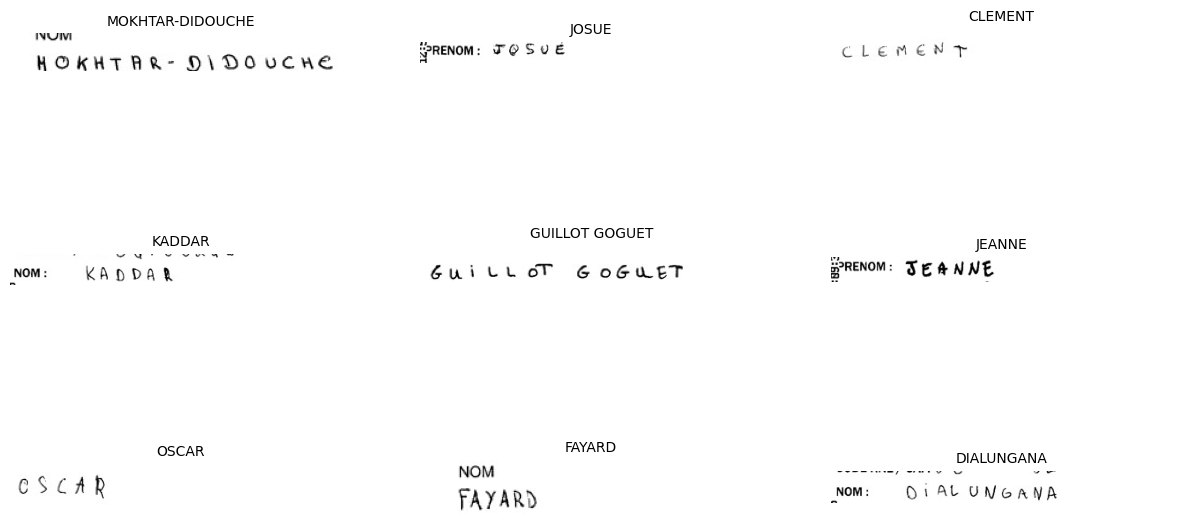

In [29]:
def visualization_data(data_csv, image_dir):
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the bounding boxes
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.randint(0, 1000)
        # Load the image
        image_path = os.path.join(image_dir, data_csv.loc[idx, 'FILENAME'])
        image = cv2.imread(image_path, 0)
        axs[row, col].imshow(image, cmap = 'gray')
        axs[row, col].set_title(data_csv.loc[idx, 'IDENTITY'], fontsize=10)
        axs[row, col].axis('off')
    plt.show()
    
visualization_data(train_csv, train_img_dir)

In [30]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE']
print(train_csv.shape[0], val_csv.shape[0])

330859 41358


In [31]:
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64 # max length of predicted labels: 64
batch_size = 512

def encode_to_label(text):
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx!=-1 else alphabets.find('-'))
    
    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

name = 'QUY DAU'
print(name, '\n', encode_to_label(name))

QUY DAU 
 [16 20 24 27  3  0 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [32]:
def decode_to_text(number_arr):
    text = ''
    for number in number_arr:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

decode_to_text([16, 20, 24, 27, 3, 0, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

'QUY DAU'

In [33]:
@tf.function
def preprocess_image(image_path, label, label_len):
    # Read image
    file = tf.io.read_file(image_path)
    # Decode and convert to grayscale
    image = tf.image.decode_png(file, channels=1)
    # Convert to float32 in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, [64, 256])
    # Compute the input_len
    input_len = [num_of_timestamps - 2]
    
    return image, label, input_len, label_len, [0]

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function for Create list of image data
def create_data_list(data_csv, img_dir):
    data_x, data_y, label_len = [], [], []
    for idx, row in data_csv.iterrows():
        if isinstance(row['IDENTITY'], str):
            data_x.append(os.path.join(img_dir, row['FILENAME']))
            text = row['IDENTITY'].upper()
            data_y.append(encode_to_label(text))
            label_len.append(len(text))
        
    return data_x, data_y, label_len

# Function for Create tensorflow dataset
def create_tf_dataset(data_x, data_y, label_len):
    dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y, label_len))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
    dataset = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [35]:
# Create tensorflow Dataset for train data
train_x, train_y, train_label_len = create_data_list(train_csv, train_img_dir)
train_dataset = create_tf_dataset(train_x, train_y, train_label_len)

# Create tensorflow Dataset for val data
val_x, val_y, val_label_len = create_data_list(val_csv, val_img_dir)
val_dataset = create_tf_dataset(val_x, val_y, val_label_len)

print(len(train_y), len(val_y))

330294 41280


In [36]:
# Defining the CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [37]:
# Define the Convolutional Block
def conv_block(num_filters, use_max_pool=True, pool_size=(4, 2), stride=2):
    cnn = Sequential()
    cnn.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=pool_size, strides=stride))
    return cnn
    
# Define the CRNN Model
def CRNN():
    # Inputs
    inputs = Input(shape=(64, 256, 1), name='image')
    labels = Input(name="label", shape=(None,), dtype="float32")
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    # CNN
    conv1 = conv_block(32)(inputs)
    conv2 = conv_block(64)(conv1)
    conv3 = conv_block(128, pool_size=(4, 1), stride=1)(conv2)
    conv4 = conv_block(256, pool_size=(4, 1), stride=1)(conv3)
    conv5 = conv_block(128, pool_size=(5, 1), stride=1)(conv4)
    
    # CNN --> RNN
    reshape = Reshape((num_of_timestamps, 512))(conv5)
    dense = Dense(num_of_timestamps, activation='relu')(reshape)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.2)(bn)
    
    # RNN
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(dropout)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(lstm1)
    
    # Outputs
    y_pred = Dense(num_of_characters, activation = 'softmax')(lstm2)
    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    pred_model = Model(inputs=inputs, outputs=y_pred)
    train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)
    
    return pred_model, train_model

model, train_model = CRNN()
train_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 64, 256,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 31, 128,   │        448 │ image[0][0]       │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 14, 64,    │     18,752 │ sequential_5[0][… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 11, 64,    │     74,368 │ sequential_6[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 8, 64,     │    296,192 │ sequential_7[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 64,     │    295,552 │ sequential_8[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 512)   │          0 │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64, 64)    │     32,832 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64, 128)   │     66,048 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64, 128)   │     98,816 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64, 30)    │      3,870 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc (Lambda)        │ (None, 1)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ label[0][0],      │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 887,134 (3.38 MB)

 Trainable params: 885,790 (3.38 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [46]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

# Compile the model
train_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

filepath = "best_model.weights.h5"  # Adjusted filepath format

# Define callbacks
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto')

earlyStopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callbacks_list = [checkpoint, earlyStopping]

# Assuming train_dataset and val_dataset are properly defined
history = train_model.fit(train_dataset,
                          epochs=30,
                          validation_data=val_dataset,
                          verbose=1,
                          shuffle=True,
                          callbacks=callbacks_list)

# Save the entire model
train_model.save('my_model.h5')


Epoch 1/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 24.0926
Epoch 1: val_loss improved from inf to 8.62578, saving model to best_model.weights.h5
646/646 ━━━━━━━━━━━━━━━━━━━━ 6210s 10s/step - loss: 24.0737 - val_loss: 8.6258
Epoch 2/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 3.7274
Epoch 2: val_loss improved from 8.62578 to 4.16356, saving model to best_model.weights.h5
646/646 ━━━━━━━━━━━━━━━━━━━━ 6304s 10s/step - loss: 3.7269 - val_loss: 4.1636
Epoch 3/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 2.8209
Epoch 3: val_loss did not improve from 4.16356
646/646 ━━━━━━━━━━━━━━━━━━━━ 6190s 10s/step - loss: 2.8207 - val_loss: 4.2895
Epoch 4/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 2.4368
Epoch 4: val_loss did not improve from 4.16356
646/646 ━━━━━━━━━━━━━━━━━━━━ 6217s 10s/step - loss: 2.4367 - val_loss: 17.0226
Epoch 5/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 2.2433
Epoch 5: val_loss did not improve from 4.16356
646/646 ━━━━━━━━━━━━━━━━━━━━ 6100s 9s/

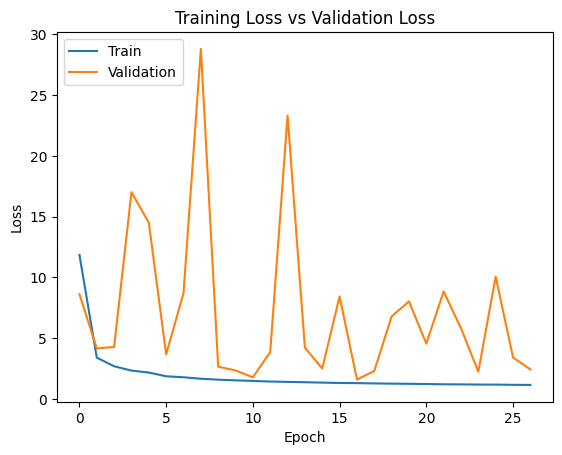

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [49]:
model.load_weights('best_model.weights.h5')

In [50]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indices = np.argmax(predictions, axis=2)
    
    for i in range(pred_indices.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indices[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(alphabets):
                ans += alphabets[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [51]:
def get_predictions_and_labels(dataset, model):
    """
    Input: Tensorflow Dataset and the model to predict
    Output: Extract labels from dataset and get prediction from the model
    """
    predictions, labels = [], []
    for batch in dataset.as_numpy_iterator():
        images, num_labels = batch[0][0], batch[0][1]
        preds = model.predict(images)
        predictions.extend(ctc_decoder(preds))
        labels.extend([decode_to_text(num_labels[i]) for i in range(len(num_labels))])
    
    return predictions, labels

predictions, labels = get_predictions_and_labels(val_dataset, model)
print(len(predictions), len(labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
16/16 ━━━━━━━━━━

In [52]:
def get_accuracy_characters_and_words(predictions, labels):
    """
    Input: The predictions and labels text of validation data
    Output: The accuracy about words and characters
    """
    word_accuracy = np.mean([predictions[i] == labels[i] for i in range(len(predictions))])
    num_correct_char, len_char = 0, 0
    for i in range(len(predictions)):
        num_correct_char += np.sum([predictions[i][j] == labels[i][j] for j in range(min(len(predictions[i]), len(labels[i])))])
        len_char += len(labels[i])
    
    character_accuracy = num_correct_char/ float(len_char)
    return word_accuracy, character_accuracy

word_accuracy, character_accuracy = get_accuracy_characters_and_words(predictions, labels)
print('Character accuracy in the validation set: {} %'.format(round(character_accuracy * 100, 3)))
print('Word accuracy in the validation set: {} %'.format(round(word_accuracy * 100, 3)))

Character accuracy in the validation set: 91.207 %
Word accuracy in the validation set: 77.498 %


In [53]:
test_img_dir = 'Handwriting_Recognition/test_v2/test'
test_csv = pd.read_csv('Handwriting_Recognition/written_name_test_v2.csv')

# Create test dataset with TensorFlow format
test_x, test_y, test_label_len = create_data_list(test_csv, test_img_dir)
test_dataset = create_tf_dataset(test_x, test_y, test_label_len)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step


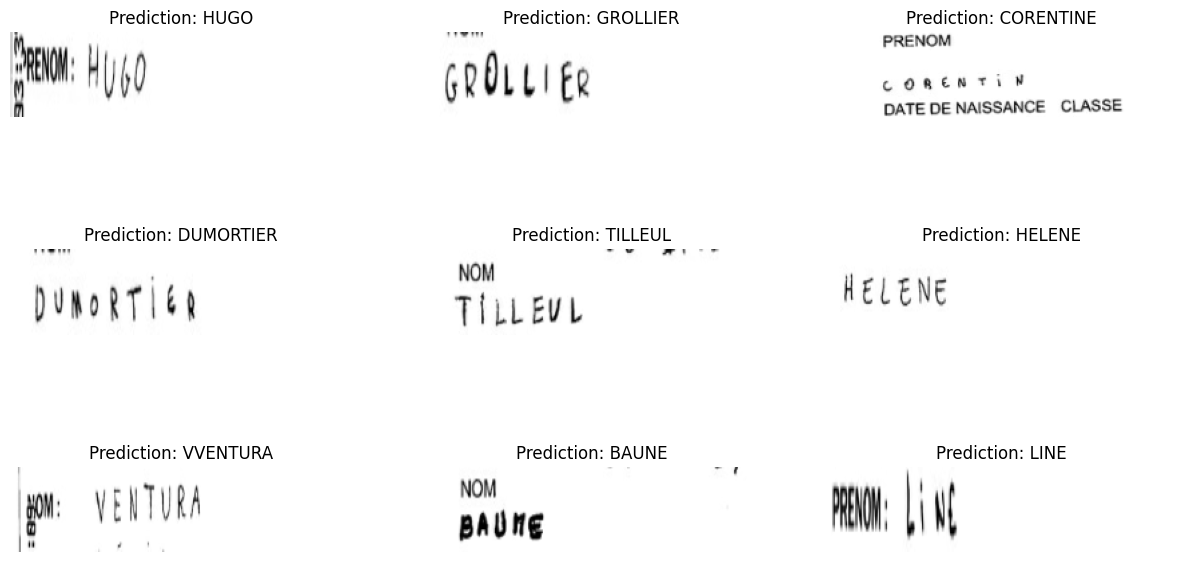

In [54]:
def test_images_data_with_model_prediction(model, dataset):
    # Create predictions for a batch in this dataset
    for batch in dataset.as_numpy_iterator():
        images = batch[0][0]
        predictions = ctc_decoder(model.predict(images))
        break
    
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the image with prediction model
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.randint(0, batch_size)
        axs[row, col].imshow(images[idx], cmap = 'gray')
        axs[row, col].set_title('Prediction: {}'.format(predictions[idx]), fontsize=12)
        axs[row, col].axis('off')
    plt.show()

test_images_data_with_model_prediction(model, test_dataset)